<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/04-transfer-learning/03_residual_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning: Residual Connections

Now, let's consider what is Transfer learning?

The idea is quite simple. First, some big tech company, which has access to virtually
infinite amounts of data and computing power, develops and trains a huge model
for their own purpose. 

Next, once it is trained, its architecture and the corresponding trained weights (the pre-trained model) are released. Finally,
everyone else can use these weights as a starting point and fine-tune them
further for a different (but similar) purpose.

That’s transfer learning in a nutshell.

##Setup

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter7()
# This is needed to render the plots in this chapter
from plots.chapter7 import *

Finished!


In [ ]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
#from torchvision.models.alexnet import model_urls
try:
  from torchvision.models.utils import load_state_dict_from_url
except ImportError:
  from torch.hub import load_state_dict_from_url

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

unzip -qq rock-paper-scissors-dataset.zip
rm -rf rock-paper-scissors-dataset.zip

 99% 449M/452M [00:04<00:00, 122MB/s]
100% 452M/452M [00:04<00:00, 98.1MB/s]


## Data Preparation

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images.Besides, we can use the ImageFolder dataset now.

The Rock Paper Scissors dataset is organized like that:

```
rps/paper/paper01-000.png
rps/paper/paper01-001.png

rps/rock/rock01-000.png
rps/rock/rock01-001.png

rps/scissors/scissors01-000.png
rps/scissors/scissors01-001.png
```

The dataset is also perfectly balanced, with each sub-folder containing 840 images
of its particular class.

In [ ]:
ROOT_FOLDER = "Rock-Paper-Scissors"

Since we’re using a pre-trained model, we need to use the standardization
parameters used to train the original model. 

In other words, we need to use the
statistics of the original dataset used to train that model.

So, the data preparation step for the Rock Paper Scissors dataset looks like this now:

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
composer = Compose([
  Resize(256),
  CenterCrop(224),
  ToTensor(),
  normalizer
])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

##Batch Normalization

The need for normalization layers in order to
prevent (or mitigate) an issue commonly called "internal covariate shift," which is
just fancy for having different distributions of activation values in different layers.

In general, we would like to have all layers produce activation values with similar
distributions, ideally with zero mean and unit standard deviation.

For a mini-batch of `n` data points, given one particular feature `x`, batch
normalization will first compute the statistics for that mini-batch:

$$
\Large
\overline{X} = \frac{1}{n}\sum_{i=1}^n{x_i}
\\
\Large
\sigma(X) = \sqrt{\frac{1}{n}\sum_{i=1}^n{(x_i - \overline{X})^2}}
$$

Then, it will use these statistics to standardize each data point in the mini-batch:

$$
\Large
\text{standardized }x_i = \frac{x_i-\overline{X}}{\sigma(X)+ \epsilon}
$$

The actual difference is the optional affine transformation at the end:

$$
\Large
\text{batch normed }x_i = b + w \text{ standardized }x_i
$$

Although I’ve chosen the familiar `b` and `w `to represent these parameters, so it becomes even more clear there is
nothing special to this transformation, you’ll find them represented as `beta` and
`gamma`, respectively, in the literature.

Moreover, the terms may appear in a
different order, like this:

$$
\Large
\text{batch normed }x_i = \text{standardized }x_i\ \gamma + \beta
$$

###Running Statistics

Since batch normalization computes statistics on mini-batches, and mini-batches
contain a small number of points, these statistics are likely to fluctuate a lot. The
smaller the mini-batches, the more the statistics will fluctuate.

During the evaluation phase (or when the model is already trained and deployed),
there are no mini-batches. It is perfectly natural to feed the model a single input to
get its prediction. 

Clearly, there are no statistics for a single data point: It is its own
mean, and the variance is zero. 

How can you standardize that? You can’t!

What about keeping track of running statistics (that is, moving averages of the
statistics)? 

It is a good way of smoothing the fluctuations.

Let’s see it in action using code—we’ll use a dummy dataset with 200 random data
points and two features:

In [ ]:
torch.manual_seed(23)

dummy_points = torch.randn((200, 2)) + torch.randn((200, 2)) * 2
dummy_labels = torch.randint(2, (200, 1))

dummy_dataset = TensorDataset(dummy_points, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

A mini-batch of size 64 is small enough to have fluctuating statistics and large
enough for plotting decent histograms.

Let’s fetch three mini-batches and plot histograms corresponding to each feature
in the first mini-batch:

In [ ]:
iterator = iter(dummy_loader)

batch1 = next(iterator)
batch2 = next(iterator)
batch3 = next(iterator)

It is said that batch normalization enforces a lower limit on mini-batch size.

The problem is the natural fluctuation of the statistics.

The flip side is that the fluctuation of the statistics is actually injecting
randomness into the training process, thus having a regularizing effect and
impacting positively the training of the model.

As we know another regularization procedure: dropout. Its
way of injecting randomness was zeroing some of the inputs, such that its
output would also vary slightly, or fluctuate.

**Since both batch normalization and dropout layers have a regularizing effect, combining both layers may actually harm the model performance.**

In [ ]:
mean1, var1 = batch1[0].mean(axis=0), batch1[0].var(axis=0)
mean1, var1

(tensor([-0.2283, -0.2116]), tensor([3.7427, 4.7615]))

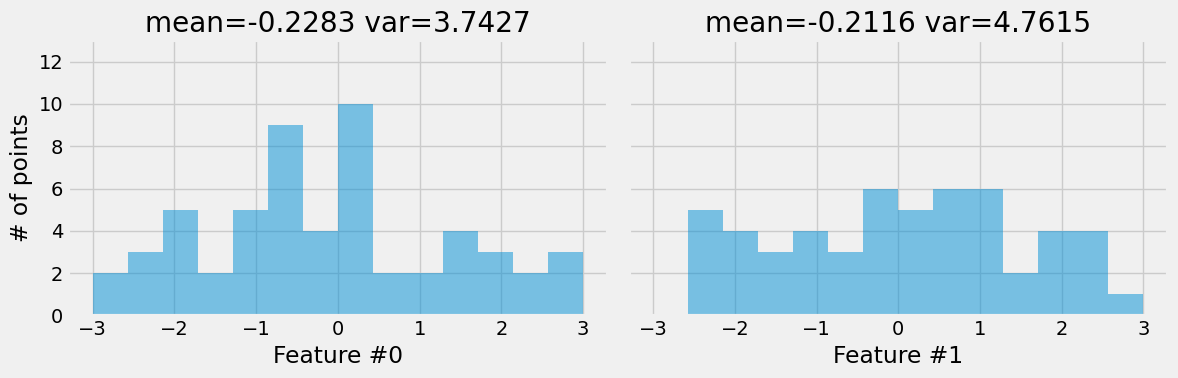

In [ ]:
fig = before_batchnorm(batch1)

These features can surely benefit from some standardization. We’ll use
`nn.BatchNorm1d` to accomplish it:

In [ ]:
batch_normalizer = nn.BatchNorm1d(num_features=2, affine=False, momentum=None)
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

Let’s see what happens to them after we normalize our first
mini-batch:

In [ ]:
normed1 = batch_normalizer(batch1[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([-0.2283, -0.2116])),
             ('running_var', tensor([3.7427, 4.7615])),
             ('num_batches_tracked', tensor(1))])

Let’s double-check it.

In [ ]:
normed1.mean(axis=0), normed1.var(axis=0)

(tensor([7.4506e-09, 3.7253e-09]), tensor([1.0159, 1.0159]))

I confess I find this a bit annoying too—the running variance is
unbiased, but the actual standardization of the data points of a mini-batch uses a
biased variance.

What’s the difference between the two?

The difference lies in the denominator only:

$$
\Large
\begin{aligned}
\text{Biased Var}(X) &= \frac{1}{n} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\\
\text{Var}(X) &= \frac{1}{n-1} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\end{aligned}
$$

In [ ]:
normed1.var(axis=0, unbiased=False)

tensor([1.0000, 1.0000])

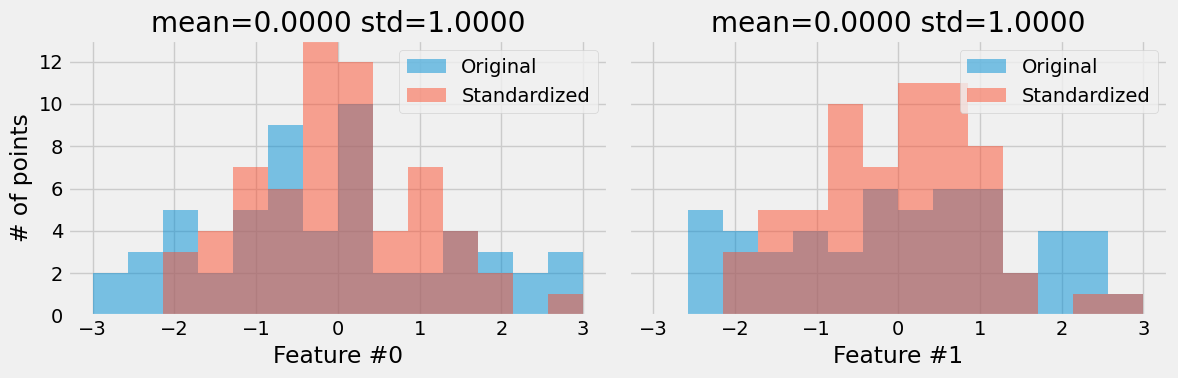

In [ ]:
fig = after_batchnorm(batch1, normed1)

Even though batch normalization achieved an output with zero mean and unit
standard deviation, the overall distribution of the output is still mostly determined
by the distribution of the inputs.

>Batch normalization won’t turn it into a normal distribution.

If we feed the second mini-batch to the batch normalizer, it will update its running
statistics accordingly:

In [ ]:
normed2 = batch_normalizer(batch2[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([-0.1930, -0.0222])),
             ('running_var', tensor([4.1655, 4.5009])),
             ('num_batches_tracked', tensor(2))])

Both running mean and running variance are simple averages over the minibatches:

In [ ]:
mean2, var2 = batch2[0].mean(axis=0), batch2[0].var(axis=0)

running_mean, running_var = (mean1 + mean2) / 2, (var1 + var2) / 2
running_mean, running_var

(tensor([-0.1930, -0.0222]), tensor([4.1655, 4.5009]))

###Evaluation Phase

Just like dropout, batch normalization exhibits different behaviors depending on
the mode: train or eval. We’ve already seen what it does during the training
phase. We’ve also realized that it doesn’t make sense to compute statistics for any
data that isn’t training data.

So, in the evaluation phase, it will use the running statistics computed during
training to standardize the new data (the third mini-batch, in our small example):

In [ ]:
batch_normalizer.eval()

normed3 = batch_normalizer(batch3[0])
normed3.mean(axis=0), normed3.var(axis=0, unbiased=False)

(tensor([0.1350, 0.1450]), tensor([1.0134, 1.2981]))

Since it is standardizing unseen data using statistics computed on
training data, the results above are expected. 

The mean will be around zero and
the standard deviation will be around one.

###Momentum

There is an alternative way of computing running statistics: Instead of using a
simple average, it uses an exponentially weighted moving average (EWMA) of the
statistics.

So, to make it abundantly clear what is being computed, I present the formulas
below:

$$
\large
\begin{array}
& \text{EWMA}_t(\alpha, x) &= &\alpha &x_t &+ &(1-\alpha) &\text{EWMA}_{t-1}(\alpha, x)
\\
\text{running stat}_t &= &\text{"momentum"} &\text{stat}_t &+ &(1-\text{"momentum"}) &\text{running stat}_{t-1}
\end{array}
$$

Let’s try it out in practice.

In [ ]:
batch_normalizer_mom = nn.BatchNorm1d(num_features=2, affine=False, momentum=0.1)
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

What happens if we run
the first mini-batch through it?

In [ ]:
normed1_mom = batch_normalizer_mom(batch1[0])
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([-0.0228, -0.0212])),
             ('running_var', tensor([1.2743, 1.3761])),
             ('num_batches_tracked', tensor(1))])

We can easily verify the results for the running
means:

In [ ]:
running_mean = torch.zeros((1, 2))
running_mean = 0.1 * batch1[0].mean(axis=0) + (1 - 0.1) + running_mean
running_mean

tensor([[0.8772, 0.8788]])

###BatchNorm2d

The difference between the one-dimension and the two-dimension batch
normalization is actually quite simple: The former standardizes features (columns),
while the latter standardizes channels (pixels).



In [ ]:
torch.manual_seed(39)

dummy_images = torch.rand((200, 3, 10, 10))
dummy_labels = torch.randint(2, (200, 1))

dummy_dataset = TensorDataset(dummy_images, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

iterator = iter(dummy_loader)
batch1 = next(iterator)
batch1[0].shape

torch.Size([64, 3, 10, 10])

The batch normalization is done over the C dimension, so it will compute statistics
using the remaining dimensions—N, H, and `W (axis=[0, 2, 3])`—representing all
pixels of a given channel from every image in the mini-batch.

The `nn.BatchNorm2d` layer has the same arguments as its one-dimension
counterpart, but its num_features argument must match the number of channels
of the input instead:

In [ ]:
batch_normalizer = nn.BatchNorm2d(num_features=3, affine=False, momentum=None)
normed1 = batch_normalizer(batch1[0])
normed1.mean(axis=[0, 2, 3]), normed1.var(axis=[0, 2, 3], unbiased=False)

(tensor([ 2.3283e-08, -2.3693e-08,  8.8960e-08]),
 tensor([0.9999, 0.9999, 0.9999]))

As expected, each channel in the output has its pixel values with zero mean and
unit standard deviation.

##Summary

It goes over a lot
of information while only scratching the surface of this topic. So, I am organizing a
small summary of the main points we’ve addressed:

* During training time, batch normalization computes statistics (mean and
variance) for each individual mini-batch and uses these statistics to produce
standardized outputs.

* The fluctuations in the statistics from one mini-batch to the next introduce
randomness into the process and thus have a regularizing effect.

* Due to the regularizing effect of batch normalization, it may not work well if combined with other regularization techniques (like dropout).

* During evaluation time, batch normalization uses a (smoothed) average of the
statistics computed during training.

* Its original motivation was to address the so-called internal covariate shift by
producing similar distributions across different layers, but it was later found
that it actually improves model training by making the loss surface smoother.

* The batch normalization may be placed either before or after the activation
function; there is no "right" or "wrong" way.

* The layer preceding the batch normalization layer should have its bias=False
set to avoid useless computation.

* Even though batch normalization works for a different reason than initially
thought, addressing the internal covariate shift may still bring benefits, like
solving the vanishing gradients problem.

